# Toxic comment analysis using GRU

---


## Load libraries


In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd

## Load Dataset


In [3]:
data = pd.read_csv("datasets/train.csv")
data.head()

id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\r\nWhy the edits made under my use...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\r\nMore\r\nI can't make any real suggestions...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0

### Clean the data


In [4]:
print("Number of missing values in each column :")
print(data.isnull().sum())

Number of missing values in each column :
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


We will remove the rows with missing values and remove the id column as it is not relevant.


In [5]:
data = data.dropna()
del data["id"]

Our data is now clean and ready for analysis !


In [6]:
data.head()

comment_text  toxic  severe_toxic  \
0  Explanation\r\nWhy the edits made under my use...      0             0   
1  D'aww! He matches this background colour I'm s...      0             0   
2  Hey man, I'm really not trying to edit war. It...      0             0   
3  "\r\nMore\r\nI can't make any real suggestions...      0             0   
4  You, sir, are my hero. Any chance you remember...      0             0   

   obscene  threat  insult  identity_hate  
0        0       0       0              0  
1        0       0       0              0  
2        0       0       0              0  
3        0       0       0              0  
4        0       0       0              0

In [7]:
from helpers.data.dataset import print_data_composition

print_data_composition(data)

Number of neutral comments : 143346

Number of toxic comments : 16225
| number of severe_toxic : 1595
| number of obscene : 8449
| number of threat : 478
| number of insult : 7877
| number of identity_hate : 1405


There is clearly imbalanced. The number of neutral comments is way greater than the number of toxic comments


## Rebalance the dataframe using downsampling

We remove neutral comments to balance the dataset


In [8]:
print_data_composition(data)

Number of neutral comments : 143346

Number of toxic comments : 16225
| number of severe_toxic : 1595
| number of obscene : 8449
| number of threat : 478
| number of insult : 7877
| number of identity_hate : 1405


In [9]:
# count the number of comments that have at least one label set to 1
toxic_comments = data[(data["toxic"] == 1) |
                      (data["severe_toxic"] == 1) |
                      (data["obscene"] == 1) |
                      (data["threat"] == 1) |
                      (data["insult"] == 1) |
                      (data["identity_hate"] == 1)]

toxic_comments


comment_text  toxic  \
6            COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK      1   
12      Hey... what is it..\r\n@ | talk .\r\nWhat is i...      1   
16      Bye! \r\n\r\nDon't look, come or think of comm...      1   
42      You are gay or antisemmitian? \r\n\r\nArchange...      1   
43               FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!      1   
...                                                   ...    ...   
159494  "\r\n\r\n our previous conversation \r\n\r\nyo...      1   
159514                  YOU ARE A MISCHIEVIOUS PUBIC HAIR      1   
159541  Your absurd edits \r\n\r\nYour absurd edits on...      1   
159546  "\r\n\r\nHey listen don't you ever!!!! Delete ...      1   
159554  and i'm going to keep posting the stuff u dele...      1   

        severe_toxic  obscene  threat  insult  identity_hate  
6                  1        1       0       1              0  
12                 0        0       0       0              0  
16                 0        0       0       0              0  
42                 0        1       0       1              1  
43                 0        1       0       1              0  
...              ...      ...     ...     ...            ...  
159494             0        1       0       1              1  
159514             0        0       0       1              0  
159541             0        1       0       1              0  
159546             0        0       0       1              0  
159554             0        1       0       1              0  

[16225 rows x 7 columns]

### Downsample the data


In [10]:
num_toxic_comments = len(toxic_comments)
num_neutral_comments = len(data[(data["toxic"] == 0) &
                                (data["severe_toxic"] == 0) &
                                (data["obscene"] == 0) &
                                (data["threat"] == 0) &
                                (data["insult"] == 0) &
                                (data["identity_hate"] == 0)])

num_samples = min(num_toxic_comments, num_neutral_comments)

neutral_comments = data[(data["toxic"] == 0) &
                        (data["severe_toxic"] == 0) &
                        (data["obscene"] == 0) &
                        (data["threat"] == 0) &
                        (data["insult"] == 0) &
                        (data["identity_hate"] == 0)].sample(n=num_samples * 2)

data = pd.concat([toxic_comments, neutral_comments])

print_data_composition(data)

Number of neutral comments : 32450

Number of toxic comments : 16225
| number of severe_toxic : 1595
| number of obscene : 8449
| number of threat : 478
| number of insult : 7877
| number of identity_hate : 1405


### Clean the comments


In [11]:
data["comment_text"].head()

6          COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
12    Hey... what is it..\r\n@ | talk .\r\nWhat is i...
16    Bye! \r\n\r\nDon't look, come or think of comm...
42    You are gay or antisemmitian? \r\n\r\nArchange...
43             FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!
Name: comment_text, dtype: object

In [12]:
from helpers.data.process_comment import process_comment
from helpers.data.text_manipulation import TextManipulation

text_manipulator = TextManipulation()

comments = data["comment_text"].to_numpy()

labels_columns = [
    "toxic",
    "severe_toxic",
    "obscene",
    "threat",
    "insult",
    "identity_hate",
]
labels = data[labels_columns].to_numpy()

for i, comment in enumerate(comments):
    comments[i] = process_comment(comment)



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mathi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mathi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mathi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mathi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mathi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mathi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopword

### Tokenize the comments


In [13]:
MAX_TOKENS = 1500

In [15]:
from keras.preprocessing.text import Tokenizer
import numpy as np
from keras.utils import pad_sequences

tokenizer = Tokenizer(num_words=MAX_TOKENS, oov_token="<OOV>")
tokenizer.fit_on_texts(comments)

vocab_size = len(tokenizer.word_index) + 1

In [16]:
sequences = tokenizer.texts_to_sequences(comments)
comments = pad_sequences(sequences, padding="post", maxlen=MAX_TOKENS)

In [17]:
comments[:5, :10]

array([[587, 144,   3,   1, 296,  17,  24, 157,   0,   0],
       [331,  35,   8,  12,  53,  35,   8,  12,  32,   1],
       [  1,  21,  11, 155, 228,  28,  72,   9,   1, 152],
       [  3,  14, 148,  28,   1,   1, 609,   1,   1,   1],
       [ 47,  20,   1, 538,  13,   2, 121,   1,   0,   0]])

## Analyse the text


### Split the training and test data


In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(comments, labels, test_size=0.2, random_state=42)

In [19]:
print(f"Train data samples : {len(X_train)}")
print(f"Test data samples : {len(X_test)}")

Train data samples : 38940
Test data samples : 9735


In [20]:
MODEL_PATH = "models/GRU"

In [21]:
import os

os.makedirs(MODEL_PATH, exist_ok=True)

In [22]:
import joblib

with open(f"{MODEL_PATH}/vectorizer.pkl", "wb") as f:
    joblib.dump(tokenizer, f)

## Callbacks


## Build the model

### Load GloVe embeddings


In [23]:
EMBEDDING_DIM = 100
GLOVE_PATH = 'datasets/glove.6B.100d.txt'

In [24]:
embeddings_index = {}
with open(GLOVE_PATH) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs

embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    if i < MAX_TOKENS:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

### CSV Logger


In [25]:
from tensorflow.keras.callbacks import CSVLogger

csv_callback = CSVLogger(
    f"{MODEL_PATH}/metrics.csv"
)

### Model checkpoint


In [26]:
from tensorflow.keras.callbacks import ModelCheckpoint

model_checkpoint_callback = ModelCheckpoint(
    filepath=f"{MODEL_PATH}/model.keras",
    monitor='val_loss',
    mode='min',
    save_best_only=True)

## Model Architecture


In [27]:
DROPOUT = 0.2

In [31]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Bidirectional, GlobalMaxPool1D, GRU, Embedding, BatchNormalization, \
    Dropout
from tensorflow.keras.initializers import Constant

number_of_classes = len(labels_columns)

model = Sequential()

model.add(Input(shape=(MAX_TOKENS,)))
model.add(Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM,
                    embeddings_initializer=Constant(embedding_matrix), trainable=False))
#
model.add(GRU(EMBEDDING_DIM, return_sequences=False))
model.add(Dropout(DROPOUT))

#
model.add(Dense(EMBEDDING_DIM, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(DROPOUT))
#
model.add(Dense(number_of_classes, activation="sigmoid"))

model.compile(optimizer="adam", metrics=["accuracy"], loss="binary_crossentropy")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1500, 100)         10900800  
                                                                 
 gru_2 (GRU)                 (None, 100)               60600     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 batch_normalization_1 (Bat  (None, 100)               400       
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 100)               0         
                                                      

## Model training


In [33]:
NUM_EPOCHS = 1
BATCH_SIZE = 32

In [34]:
history = model.fit(
    X_train,
    y_train,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    callbacks=[model_checkpoint_callback, csv_callback],
)

974/974 [==============================] - 608s 624ms/step - loss: 0.3309 - accuracy: 0.9507 - val_loss: 0.3143 - val_accuracy: 0.9802


## Evaluate the model


### Show the training history


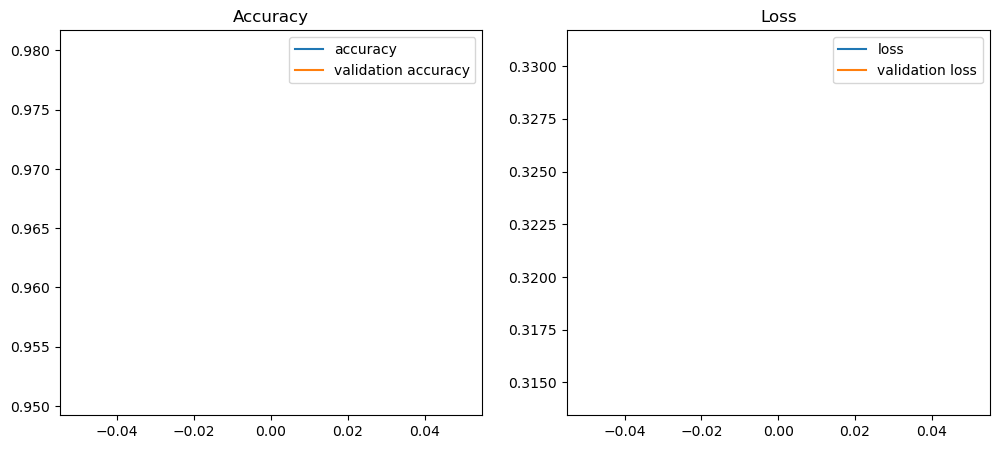

In [39]:
from helpers.data.show_training_metrincs import show_training_metrics

show_training_metrics(f"{MODEL_PATH}/metrics.csv")

### Evaluate the model on the test data


In [36]:
evaluation = model.evaluate(X_test, y_test)
print(evaluation)

305/305 [==============================] - 61s 199ms/step - loss: 0.3121 - accuracy: 0.9811
[0.3120858073234558, 0.9810991287231445]


In [37]:
sentence = ["I love you so much, you are the best person in the world"]

sentence = process_comment(sentence[0])
print(sentence)

sentence = tokenizer.texts_to_sequences([sentence])
print(sentence)
sentence = pad_sequences(sentence, padding="post", maxlen=MAX_TOKENS)

print(sentence)

prediction = model.predict(sentence)
print(labels_columns)
print(prediction)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mathi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


i love you so much you are the best person in the world
[[5, 336, 3, 37, 140, 3, 14, 2, 187, 200, 13, 2, 251]]
[[  5 336   3 ...   0   0   0]]
1/1 [==============================] - 1s 638ms/step
['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
[[0.342213   0.03120883 0.21736605 0.02010763 0.14006095 0.0483483 ]]
